In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import gspread
from google.oauth2.service_account import Credentials
from gspread_pandas import Spread, Client

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
plt.style.use('fivethirtyeight')

In [4]:
#Getting list of S&P 500 companies from Wikipedia
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

stocks_df = pd.read_html(url, header=0)[0]

stocks_df.head()


,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",1976-08-09,66740,1902
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
2,ABBV,AbbVie Inc.,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
3,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981
4,ACN,Accenture,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [5]:
#Number of companies
len(stocks_df)

505

In [6]:
stocks_df[stocks_df['Security'].str.contains("Class")]

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
22,GOOGL,Alphabet Inc. (Class A),reports,Communication Services,Interactive Media & Services,"Mountain View, California",2014-04-03,1652044,1998
23,GOOG,Alphabet Inc. (Class C),reports,Communication Services,Interactive Media & Services,"Mountain View, California",2006-04-03,1652044,1998
201,FOXA,Fox Corporation (Class A),reports,Communication Services,Movies & Entertainment,"New York, New York",2013-07-01,1754301,2019
202,FOX,Fox Corporation (Class B),reports,Communication Services,Movies & Entertainment,"New York, New York",2015-09-18,1754301,2019
334,NWSA,News Corp (Class A),reports,Communication Services,Publishing,"New York, New York",2013-08-01,1564708,2013 (1980)
335,NWS,News Corp (Class B),reports,Communication Services,Publishing,"New York, New York",2015-09-18,1564708,2013 (1980)
456,UAA,Under Armour (Class A),reports,Consumer Discretionary,"Apparel, Accessories & Luxury Goods","Baltimore, Maryland",2014-05-01,1336917,1996
457,UA,Under Armour (Class C),reports,Consumer Discretionary,"Apparel, Accessories & Luxury Goods","Baltimore, Maryland",2016-04-08,1336917,1996


In [7]:
stocks_df['GICS Sector'].value_counts()

Information Technology    74
Industrials               74
Financials                65
Consumer Discretionary    63
Health Care               63
Consumer Staples          32
Real Estate               29
Utilities                 28
Materials                 28
Communication Services    26
Energy                    23
Name: GICS Sector, dtype: int64

In [8]:
stocks_df['GICS Sub-Industry'].value_counts()

Health Care Equipment                   20
Semiconductors                          15
Electric Utilities                      13
Industrial Machinery                    13
Packaged Foods & Meats                  12
                                        ..
Computer & Electronics Retail            1
Human Resource & Employment Services     1
Agricultural Products                    1
Diversified Chemicals                    1
Water Utilities                          1
Name: GICS Sub-Industry, Length: 124, dtype: int64

## Adding stocks data from Google Finance
Now that we have the list of S&P 500 companies, we can add to our DataFrame Google Sheets formulas that will fetch from Google Finance stock prices and the number of outstanding shares for each company. Note that, these formulas will be executed once we save the Pandas DataFrame in our Google Sheet.

You can find the documentation of GOOGLEFINANCE formulas here: https://support.google.com/docs/answer/3093281

We start by adding stock prices in 3 different dates: January 1st, March 23rd and April 9th.

January 1st, 2020 is the first date of the year. We want to have this price in order to calculate the price drop since the beggining of 2020.
March 23rd, 2020 is the date when the S&P 500 reached the bottom in 2020.
April 9th, 2020 is the last date when the stock market was open (at the time of writing this blog post)

In [9]:
stocks_df["Price_1_1"] = stocks_df["Symbol"].apply(lambda x: '=INDEX(GOOGLEFINANCE("' + x + '","price", "1/1/2020"),2,2)')
stocks_df["Price_3_23"] = stocks_df["Symbol"].apply(lambda x: '=INDEX(GOOGLEFINANCE("' + x + '","price", "3/23/2020"),2,2)')
stocks_df["Price_4_9"] = stocks_df["Symbol"].apply(lambda x: '=INDEX(GOOGLEFINANCE("' + x + '","price", "4/9/2020"),2,2)')




Next, we add the formula to calculate the number of outstanding shares for each company. We can use this data with the stock prices to calculate the market cap of companies at the 3 different dates.




In [10]:
stocks_df["Shares"] = stocks_df["Symbol"].apply(lambda x: '=GOOGLEFINANCE("' + x + '","shares")')

### Storing the DataFrame to Google Sheet
We start by creating a variable that contains our credentials that we got from Google Cloud Plaltform.

In [11]:
scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

credentials = Credentials.from_service_account_file('./Files/gsheet-stocks.json', scopes=scope)

Next, we read the empty google sheet in a variable that we call spread.

In [12]:
client = Client(scope=scope, creds=credentials)
spread = Spread("stocks_analysis", client=client)

We define the list of variables that we want to keep.

In [13]:
cols_to_keep = ["Symbol", "Security", "GICS Sector", "GICS Sub-Industry", 
                "Price_1_1", "Price_3_23", "Price_4_9", "Shares"]

The last step is to save the DataFrame to Google Sheets.

In [14]:
spread.df_to_sheet(stocks_df[cols_to_keep])



# 4. Analyzing the Data


## 4.1. Reading the data

We start by reading the data from Google Sheets into a new DataFrame.


In [15]:
stocks_df = spread.sheet_to_df()
stocks_df[['Price_1_1', 'Price_3_23', 'Price_4_9']] = stocks_df[['Price_1_1','Price_3_23', 'Price_4_9']].replace("#N/A", '0')
#stocks_df.loc[['474']]
#stocks_df.loc[['87']]

we can see that the DataFrame contains real values for stocks prices and number of shares (and not Google Sheets formulas).

We need to change the data type of stock prices and number of outstanding shares from string to numeric.

In [16]:
stocks_df[["Price_1_1", "Price_3_23", "Price_4_9", "Shares"]] = \
stocks_df[["Price_1_1", "Price_3_23", "Price_4_9", "Shares"]].apply(pd.to_numeric)


## 4.2. Adding Market Cap data and percentage change of stock prices

### Adding Market Cap Data
Next, we will add the market cap in the 3 different dates.

In [17]:
stocks_df["Marketcap_1_1"] = stocks_df["Price_1_1"] * stocks_df["Shares"]
stocks_df["Marketcap_3_23"] = stocks_df["Price_3_23"] * stocks_df["Shares"]
stocks_df["Marketcap_4_9"] = stocks_df["Price_4_9"] * stocks_df["Shares"]

## Adding percentage change of stock prices


In [18]:
# Percentage Change from January 1st to March 23rd 
stocks_df["PercentageChange_3_23_1_1"] = (stocks_df["Price_3_23"] - stocks_df["Price_1_1"]) / stocks_df["Price_1_1"]*100
# Percentage Change from March 23rd to April 9th
stocks_df["PercentageChange_4_9_3_23"] = (stocks_df["Price_4_9"] - stocks_df["Price_3_23"]) / stocks_df["Price_3_23"]*100
# # Percentage Change from January 1st to April 9th
stocks_df["PercentageChange_4_9_1_1"] = (stocks_df["Price_4_9"] - stocks_df["Price_1_1"]) / stocks_df["Price_1_1"]*100

## 4.3. Analyzing the data

### Change in the total market cap of the S&P 500

In [19]:
sum(stocks_df["Marketcap_3_23"] - stocks_df["Marketcap_1_1"]) / 10**9

-8650.67813400208

In [20]:
sum(stocks_df["Marketcap_4_9"] - stocks_df["Marketcap_3_23"]) / 10**9

4759.051320856481

In [21]:
sum(stocks_df["Marketcap_4_9"] - stocks_df["Marketcap_1_1"]) / 10**9

-3891.6268131455995

The S&P 500 lost 8.63 trillion USD from January 1st to March 23rd, but it got back 4.75 trillion from March 23rd to April 9th


## Change in the total market cap by sector

In [22]:
(stocks_df.groupby("GICS Sector").sum()["Marketcap_3_23"] - stocks_df.groupby("GICS Sector").sum()["Marketcap_1_1"]).sort_values() / 10**9

GICS Sector
Information Technology   -1586.010237
Financials               -1524.058487
Health Care              -1035.360919
Industrials              -1018.385659
Consumer Discretionary    -807.875056
Communication Services    -729.401624
Energy                    -712.375589
Consumer Staples          -446.354671
Utilities                 -266.685720
Real Estate               -263.192264
Materials                 -260.977908
dtype: float64

At the 2020 bottom of the S&P 500 (March 23rd), the Information Technology and Financials sectors had the largest drop in total market cap (compared to January 1st) with 1.592 trillion and 1.518 trillion respectively.

In [23]:
(stocks_df.groupby("GICS Sector").sum()["Marketcap_4_9"] - stocks_df.groupby("GICS Sector").sum()["Marketcap_1_1"]).sort_values() / 10**9

GICS Sector
Financials               -874.437016
Industrials              -567.703155
Information Technology   -558.553138
Energy                   -510.539006
Communication Services   -399.061497
Consumer Discretionary   -383.045243
Health Care              -264.888327
Consumer Staples         -134.559252
Materials                -105.527131
Real Estate               -52.781385
Utilities                 -40.531663
dtype: float64

As of April 9th, we can see that the Financials and Industrials sector had the largest drop in total market cap compared to January 1st.



## Ranking of companies by percentage change of stock prices

In [24]:
stocks_df.sort_values(by=["PercentageChange_4_9_1_1"])[["Security", "PercentageChange_4_9_1_1"]].head(5)

,Security,PercentageChange_4_9_1_1
index,,
344,Norwegian Cruise Line Holdings,-77.715451
87,Carnival Corp.,-75.794192
406,Royal Caribbean Group,-70.129967
298,Marathon Oil Corp.,-69.883041
82,Caesars Entertainment,-69.568140


We can see from the table above that the companies that are hardest hit are the 3 major cruises companies: Norwegian Cruise Line Holdings, Carnival Corp., Royal Caribbean Cruises Ltd. These companies saw drops in their stock price of over 70%.

In [25]:
print(sum(stocks_df["PercentageChange_4_9_1_1"] < 0))
print(sum(stocks_df["PercentageChange_4_9_1_1"] > 0))

439
66


Only 66 stocks form the 505 saw positive growth from January 1st to April 9th.


## Percentage Change of stock priced by sector

In [26]:
stocks_df.groupby("GICS Sector").mean()['PercentageChange_4_9_1_1'].sort_values()

GICS Sector
Energy                   -48.659427
Consumer Discretionary   -28.740437
Financials               -25.331719
Communication Services   -20.003368
Materials                -17.806975
Information Technology   -13.689085
Real Estate              -13.295422
Health Care               -7.305440
Consumer Staples          -7.078867
Utilities                 -6.477505
Industrials                     inf
Name: PercentageChange_4_9_1_1, dtype: float64

We can see that the energy sector was the hardest hit with a 49.8% average drop in stock prices.

Below we can visualize a boxplot of the 11 sectors' percentage change in stock prices from January 1st to April 9th.

<AxesSubplot:xlabel='GICS Sector', ylabel='PercentageChange_4_9_1_1'>

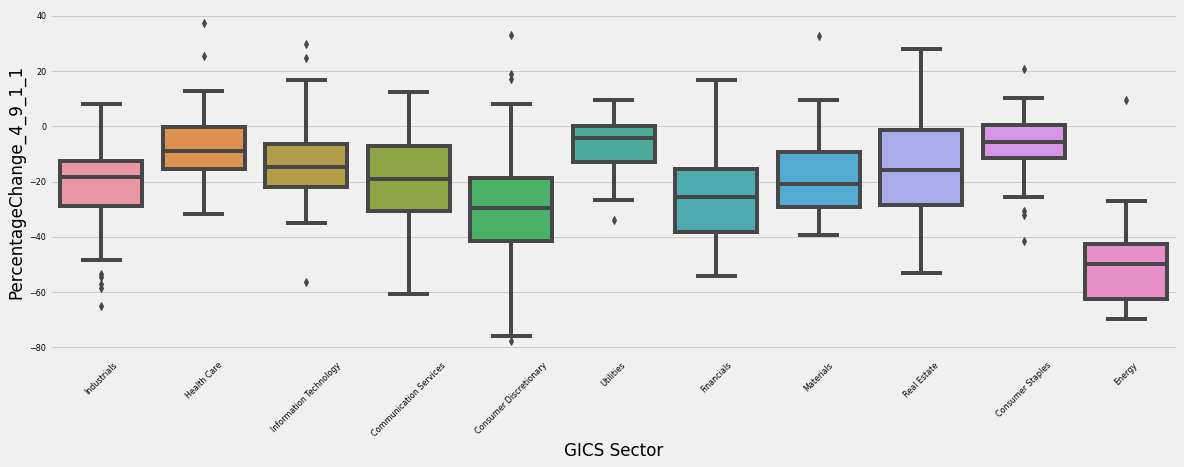

In [27]:
plt.figure(figsize=(18, 6))
plt.tick_params('both', labelsize='8')
plt.xticks(rotation=45)
sns.boxplot(x="GICS Sector", y="PercentageChange_4_9_1_1", data=stocks_df)


In [28]:
stocks_df.groupby("GICS Sub-Industry").mean()['PercentageChange_4_9_1_1'].sort_values()

GICS Sub-Industry
Hotels, Resorts & Cruise Lines       -61.709685
Oil & Gas Equipment & Services       -57.399071
Airlines                             -53.542246
Casinos & Gaming                     -51.266052
Oil & Gas Exploration & Production   -51.211968
                                        ...    
Water Utilities                        9.608985
Biotechnology                         10.572578
Gold                                  32.600648
Industrial Machinery                        inf
Building Products                           inf
Name: PercentageChange_4_9_1_1, Length: 124, dtype: float64

In [29]:
print(sum(stocks_df.groupby("GICS Sub-Industry").mean()['PercentageChange_4_9_1_1'] < 0))
print(sum(stocks_df.groupby("GICS Sub-Industry").mean()['PercentageChange_4_9_1_1'] > 0))

111
13


if we look at the average percentage change in stock prices by Sub Industry; we can see that the travel related industries, Oil & Gas and Department Stores were the hardest hit. 118 of the 138 Sub Industries had their average stock price declined from January 1st to April 9th.

<AxesSubplot:xlabel='GICS Sub-Industry'>

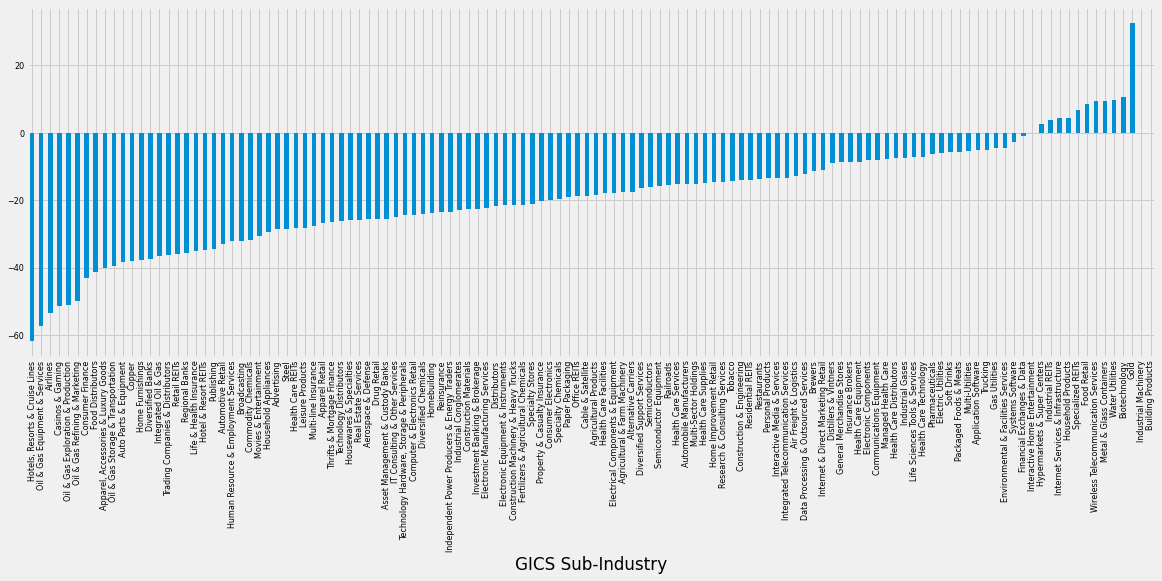

In [30]:
plt.figure(figsize=(18, 6))
plt.tick_params('both', labelsize='8')
stocks_df.groupby("GICS Sub-Industry").mean()['PercentageChange_4_9_1_1'].sort_values().plot.bar()

# Percentage Change of stock priced by Sub Industry (From March 23rf to April 9th)

In [31]:
stocks_df.groupby("GICS Sub-Industry").mean()['PercentageChange_4_9_3_23'].sort_values()

GICS Sub-Industry
Food Retail                         -0.064350
Drug Retail                          0.848429
Hypermarkets & Super Centers         5.825800
Interactive Home Entertainment       8.869739
General Merchandise Stores          10.107788
                                      ...    
Trading Companies & Distributors    51.939625
Copper                              51.948052
Real Estate Services                52.899765
Diversified Chemicals               55.535296
Household Appliances                63.111180
Name: PercentageChange_4_9_3_23, Length: 124, dtype: float64

All sectors and sub industries (except Food Retail) saw their average stock price go up from March 23rd to April 9th.

# Conclusion

In this tutorial, we learned how to use Python, Google Sheets and Google Finance to collect and analyze stock data in the context of coronavirus pandemic. We're still in the early stages of the pandemic, and we don't know yet what would be the mid to long term effect of the pandemic on both the society and the economy. It would be interesting to review this analysis in the coming weeks to see if the stock market recovers from the 2020 losses.

# References
[1] https://en.wikipedia.org/wiki/Google_Finance
